In [37]:
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
from pathlib import Path
DATA_DIR = Path('../data/twitter')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

from itertools import combinations

import cdlib
from cdlib import datasets
from cdlib import NodeClustering
from cdlib import evaluation
from cdlib import algorithms
from cdlib import viz

In [2]:
dtypes = {
    'id_str': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}
tweets = pd.read_csv(
    DATA_DIR / 'dataset_pln_20211019.csv', 
    dtype=dtypes,
    #parse_dates=['created_at']
)
print(tweets.shape)
tweets.head()

(163180, 6)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816


In [3]:
dtypes = {
    'id_str': 'str'
}
labels = pd.read_csv(DATA_DIR / 'tagged_examples.csv', usecols=['id_str', 'sentiment'], dtype=dtypes)
print(labels.shape)
labels.head()

(1090, 2)


,id_str,sentiment
0,1367998217288376320,Comentario
1,1349405168551546884,Comentario
2,1350558226765533191,Pregunta
3,1368167323379568646,Comentario
4,1364318397492830209,Apoyo


In [4]:
df = tweets.merge(labels, how='left', on='id_str')
print(df.shape)
df.head()

(163180, 7)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,NaN


In [5]:
tweet_user_map = {}
for tweet_id, user_id in tweets[['id_str', 'user.id']].values:
    tweet_user_map[tweet_id] = user_id

In [6]:
edges = df[['in_reply_to_status_id', 'id_str']].dropna()
print(len(set(edges.values.flatten())))
g = ig.Graph().DataFrame(edges, directed=False)
print(g.summary())

163441
IGRAPH UN-- 163441 159752 -- 
+ attr: name (v)


In [7]:
g = nx.DiGraph()
g.add_edges_from(edges.values)
nx.info(g)

'DiGraph with 163441 nodes and 159655 edges'

In [8]:
roots = tweets[tweets['in_reply_to_user_id'].isna()]
roots_id = roots.id_str.values
cliques = []
for idx in roots_id:
    descendants = nx.descendants(g, idx)
    clique = {tweet_user_map[desc] for desc in descendants}
    cliques.append(clique)

In [12]:
cliques = [clique for clique in cliques if len(clique)>1]
users_graph_edges = set()
for clique in cliques:
    for user1 in clique:
        for user2 in clique:
            if user1 > user2:
                user1, user2 = user2, user1
                users_graph_edges.add((user1, user2))
len(users_graph_edges)

109194

In [19]:
len(set(np.array(list(users_graph_edges)).flatten()))

42663

In [22]:
h = nx.Graph()
h.add_edges_from(users_graph_edges)
nx.info(h)

'Graph with 42663 nodes and 109194 edges'

In [26]:
nx.number_connected_components(h)

47

In [36]:
gcc_nodes = sorted([comp for comp in nx.connected_components(h)], key=len, reverse=True)[0]
gcc = nx.subgraph(h, gcc_nodes)

In [75]:
gcc = g.components().giant()
print(gcc.summary())
comp_lens = sorted([len(c) for c in g.components()], reverse=True)
comp_lens[0]
tweets_in_gcc = [v['name'] for v in gcc.vs()]

3216

In [50]:
edges.values.flatten()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [83]:
data[col].val()

544        Apoyo
1088       Apoyo
543        Apoyo
537        Apoyo
524        Apoyo
          ...   
414     Pregunta
31      Pregunta
616     Pregunta
865     Pregunta
804     Pregunta
Name: sentiment, Length: 1090, dtype: object

In [79]:
col = 'sentiment'
data = labels[labels.id_str.isin(tweets_in_gcc)]
sns.countplot(data=data, y=col, order=data[col].value_counts().index)
#lt.xticks(rotation=45);

NameError: name 'tweets_in_gcc' is not defined

In [114]:
aux = df[~df.sentiment.isna()]
grouped = aux.join(pd.get_dummies(aux['sentiment'])).groupby(by='user.id').sum()
for col in grouped.columns:
    grouped[col] = grouped[col].astype(int)
diff = grouped['Apoyo'] - grouped['Oposición']
grouped['proVac'] = diff > 0
grouped['antiVac'] = diff < 0
grouped['neutral'] = diff == 0
for col in grouped.columns:
    grouped[col] = grouped[col].astype(int)
grouped = grouped[['proVac', 'antiVac', 'neutral']]
full_df = df.merge(grouped, left_on=['user.id'], right_index=True)

991


In [116]:
user_sentiment_map = {}
for user_id, sentiment in diff.iteritems():
    if sentiment > 0:
        user_sentiment_map[user_id] = 2
    if sentiment == 0:
        user_sentiment_map[user_id] = 0
    if sentiment < 0:
        user_sentiment_map[user_id] = 1  

991
991


In [77]:
full_df[['proVac', 'antiVac', 'neutral']].sum()

proVac     9062
antiVac    7078
neutral    7737
dtype: int64

In [118]:
comms = algorithms.louvain(h)

In [83]:
comms.method_parameters

{'weight': 'weight', 'resolution': 1.0, 'randomize': None}

In [85]:
evaluation.newman_girvan_modularity(h, comms)

FitnessResult(min=None, max=None, score=0.5366404438472404, std=None)

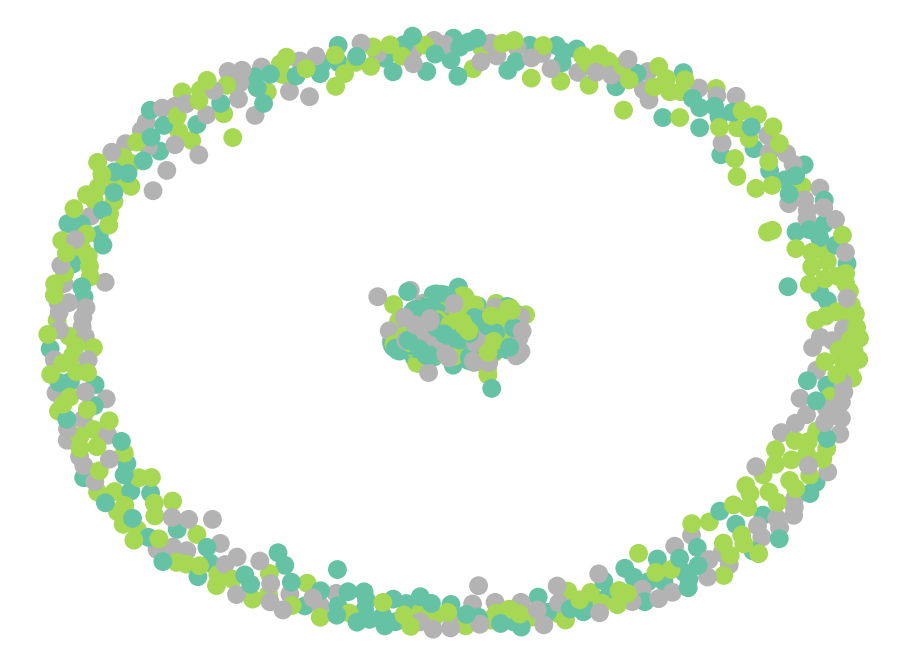

In [119]:
gcc_labeled = nx.subgraph(gcc, grouped.index)
nx.info(gcc_labeled)

color = [user_sentiment_map[user_id] for user_id in gcc_labeled.nodes()]

fig, ax = plt.subplots(figsize=(16, 12))
nx.draw(
    gcc_labeled, pos=nx.spring_layout(gcc_labeled), 
    node_color=color, cmap='Set2', ax=ax
)